In [33]:
import pandas as pd

# Load the VIX futures data from the provided CSV file
vix_data_path = 'C:/Users/PC2/Downloads/VIXData_project.csv'
vix_data = pd.read_csv(vix_data_path)

# Display the first few rows of the data to understand its structure
vix_data.head()


,Trade Date,NbDays,DaysToExpiry,VIX,future 1,future 2,future 3,future 4,future 5,future 6,future 7,future 8,future 9
0,2014-01-02,35.0,20.0,14.23,14.20,15.05,15.90,16.50,17.00,17.45,17.95,18.30,18.65
1,2014-01-03,35.0,19.0,13.76,14.05,14.90,15.80,16.40,16.95,17.35,17.90,18.25,18.65
2,2014-01-06,35.0,16.0,13.55,13.90,14.75,15.55,16.20,16.70,17.15,17.70,18.05,18.45
3,2014-01-07,35.0,15.0,12.92,13.65,14.45,15.30,15.90,16.40,16.90,17.40,17.80,18.20
4,2014-01-08,35.0,14.0,12.87,13.70,14.45,15.25,15.85,16.40,16.80,17.35,17.70,18.15


In [34]:
import numpy as np

def compute_cmf_and_roll_yields(df):
    """
    Computes the Constant Maturity Futures (CMFs) and roll yields for the one-month and five-month maturities.
    
    Args:
    - df (DataFrame): DataFrame containing VIX futures data.
    
    Returns:
    - DataFrame: DataFrame with additional columns for one-month CMF, five-month CMF, one-month roll yield,
                 and five-month roll yield.
    """
    # Initialize columns for CMFs and roll yields
    df['CMF_1M'] = np.nan
    df['CMF_5M'] = np.nan
    df['Roll_Yield_1M'] = np.nan
    df['Roll_Yield_5M'] = np.nan
    
    for i in range(len(df)):
        # Compute the weight for interpolation based on DaysToExpiry
        weight_1M = df.loc[i, 'DaysToExpiry'] / 30  # Approximate one month as 30 days
        weight_5M = (df.loc[i, 'DaysToExpiry'] - 120) / 30  # Approximate difference for five months
        
        # Ensure weights are within valid range
        weight_1M = min(max(weight_1M, 0), 1)
        weight_5M = min(max(weight_5M, 0), 1)
        
        # Interpolate to find the CMFs
        df.loc[i, 'CMF_1M'] = df.loc[i, 'future 1'] * (1 - weight_1M) + df.loc[i, 'future 2'] * weight_1M
        df.loc[i, 'CMF_5M'] = df.loc[i, 'future 5'] * (1 - weight_5M) + df.loc[i, 'future 6'] * weight_5M
        
        # Compute roll yields (difference between consecutive futures contracts)
        if i > 0:  # Ensure there's a previous day to compare with
            df.loc[i, 'Roll_Yield_1M'] = df.loc[i, 'CMF_1M'] - df.loc[i - 1, 'CMF_1M']
            df.loc[i, 'Roll_Yield_5M'] = df.loc[i, 'CMF_5M'] - df.loc[i - 1, 'CMF_5M']
    
    return df

# Compute CMFs and roll yields
vix_data_with_cmf_ry = compute_cmf_and_roll_yields(vix_data)

# Display the updated DataFrame with CMFs and roll yields
vix_data_with_cmf_ry.head()


,Trade Date,NbDays,DaysToExpiry,VIX,future 1,future 2,future 3,future 4,future 5,future 6,future 7,future 8,future 9,CMF_1M,CMF_5M,Roll_Yield_1M,Roll_Yield_5M
0,2014-01-02,35.0,20.0,14.23,14.20,15.05,15.90,16.50,17.00,17.45,17.95,18.30,18.65,14.766667,17.00,NaN,NaN
1,2014-01-03,35.0,19.0,13.76,14.05,14.90,15.80,16.40,16.95,17.35,17.90,18.25,18.65,14.588333,16.95,-1.783333e-01,-0.05
2,2014-01-06,35.0,16.0,13.55,13.90,14.75,15.55,16.20,16.70,17.15,17.70,18.05,18.45,14.353333,16.70,-2.350000e-01,-0.25
3,2014-01-07,35.0,15.0,12.92,13.65,14.45,15.30,15.90,16.40,16.90,17.40,17.80,18.20,14.050000,16.40,-3.033333e-01,-0.30
4,2014-01-08,35.0,14.0,12.87,13.70,14.45,15.25,15.85,16.40,16.80,17.35,17.70,18.15,14.050000,16.40,-1.776357e-15,0.00


In [35]:
def rolling_strategy_returns(df):
    """
    Simulates the rolling strategy and calculates returns based on CMFs and roll yields.
    
    Args:
    - df (DataFrame): DataFrame with VIX futures data, CMFs, and roll yields.
    
    Returns:
    - DataFrame: DataFrame with additional columns for strategy returns.
    """
    # Assuming risk-free rate (r) is negligible for simplicity, but can be adjusted as needed
    r = 0
    
    # Initialize columns for strategy returns
    df['Return_1M'] = np.nan
    df['Return_5M'] = np.nan
    
    for i in range(1, len(df)):  # Start from the second row since we need previous day's data
        # Calculate returns using the formula provided, incorporating roll yield and risk-free rate
        df.loc[i, 'Return_1M'] = (r + df.loc[i, 'Roll_Yield_1M']) / df.loc[i - 1, 'CMF_1M']
        df.loc[i, 'Return_5M'] = (r + df.loc[i, 'Roll_Yield_5M']) / df.loc[i - 1, 'CMF_5M']
    
    # Cumulative returns can be useful for analysis
    df['Cumulative_Return_1M'] = (1 + df['Return_1M']).cumprod() - 1
    df['Cumulative_Return_5M'] = (1 + df['Return_5M']).cumprod() - 1
    
    return df

# Calculate the returns for the rolling strategy
vix_data_with_returns = rolling_strategy_returns(vix_data_with_cmf_ry)

# Display the DataFrame with strategy returns and cumulative returns
vix_data_with_returns.head()


,Trade Date,NbDays,DaysToExpiry,VIX,future 1,future 2,future 3,future 4,future 5,future 6,...,future 8,future 9,CMF_1M,CMF_5M,Roll_Yield_1M,Roll_Yield_5M,Return_1M,Return_5M,Cumulative_Return_1M,Cumulative_Return_5M
0,2014-01-02,35.0,20.0,14.23,14.20,15.05,15.90,16.50,17.00,17.45,...,18.30,18.65,14.766667,17.00,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-01-03,35.0,19.0,13.76,14.05,14.90,15.80,16.40,16.95,17.35,...,18.25,18.65,14.588333,16.95,-1.783333e-01,-0.05,-1.207675e-02,-0.002941,-0.012077,-0.002941
2,2014-01-06,35.0,16.0,13.55,13.90,14.75,15.55,16.20,16.70,17.15,...,18.05,18.45,14.353333,16.70,-2.350000e-01,-0.25,-1.610876e-02,-0.014749,-0.027991,-0.017647
3,2014-01-07,35.0,15.0,12.92,13.65,14.45,15.30,15.90,16.40,16.90,...,17.80,18.20,14.050000,16.40,-3.033333e-01,-0.30,-2.113330e-02,-0.017964,-0.048533,-0.035294
4,2014-01-08,35.0,14.0,12.87,13.70,14.45,15.25,15.85,16.40,16.80,...,17.70,18.15,14.050000,16.40,-1.776357e-15,0.00,-1.264311e-16,0.000000,-0.048533,-0.035294


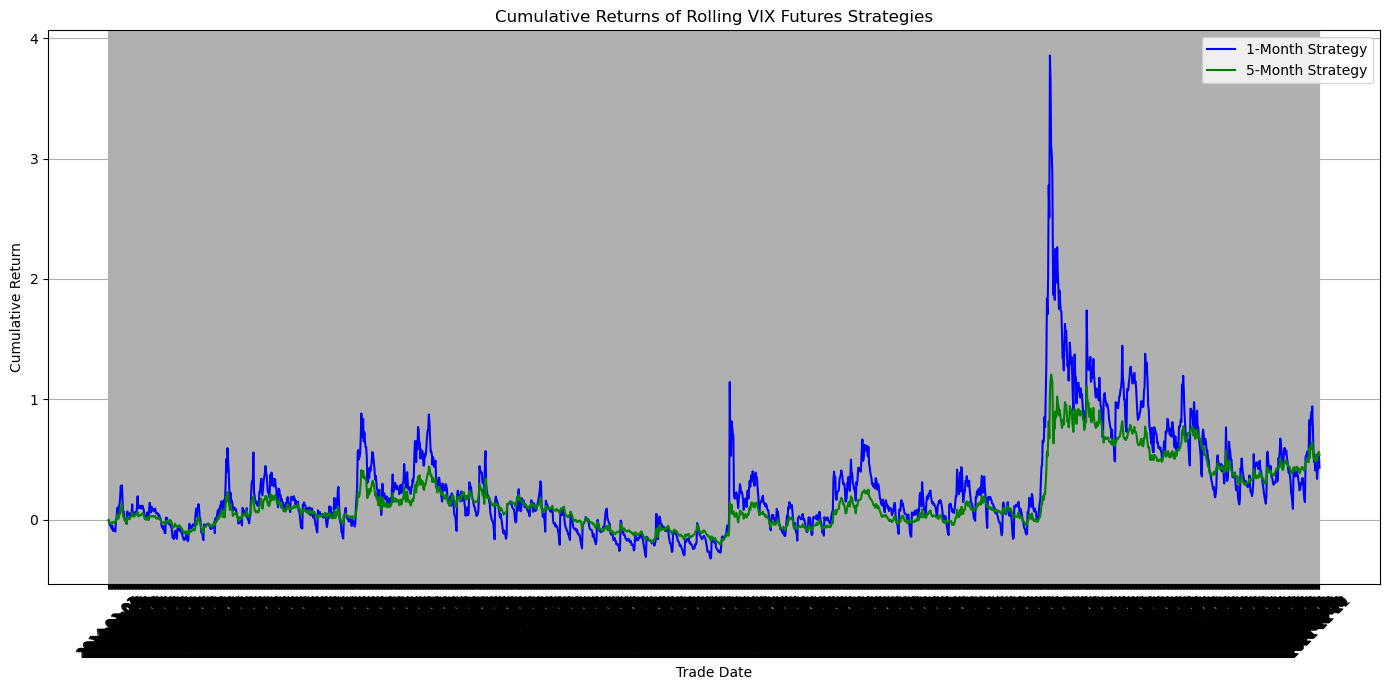

Sharpe Ratio for 1-Month Strategy: 0.51
Sharpe Ratio for 5-Month Strategy: 0.33


In [36]:
import matplotlib.pyplot as plt

# Plotting the cumulative returns for the 1-month and 5-month rolling strategies
plt.figure(figsize=(14, 7))

# Cumulative Returns for 1-month strategy
plt.plot(vix_data_with_returns['Trade Date'], vix_data_with_returns['Cumulative_Return_1M'], label='1-Month Strategy', color='blue')

# Cumulative Returns for 5-month strategy
plt.plot(vix_data_with_returns['Trade Date'], vix_data_with_returns['Cumulative_Return_5M'], label='5-Month Strategy', color='green')

plt.title('Cumulative Returns of Rolling VIX Futures Strategies')
plt.xlabel('Trade Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Calculating and displaying the Sharpe Ratios for both strategies
risk_free_rate = 0  # Assuming risk-free rate is 0 for simplicity
sharpe_ratio_1M = vix_data_with_returns['Return_1M'].mean() / vix_data_with_returns['Return_1M'].std() * np.sqrt(252)
sharpe_ratio_5M = vix_data_with_returns['Return_5M'].mean() / vix_data_with_returns['Return_5M'].std() * np.sqrt(252)

print(f"Sharpe Ratio for 1-Month Strategy: {sharpe_ratio_1M:.2f}")
print(f"Sharpe Ratio for 5-Month Strategy: {sharpe_ratio_5M:.2f}")


In [37]:
# Let's rerun the environment setup to resolve the technical issue and then proceed with the full state vector preparation

# Preparing the full state vector as specified in the paper, including log prices of all VIX futures and roll yields
def prepare_full_state_vector(df):
    """
    Prepares the full state vector Xt for the VAR model, including log prices of all VIX futures and roll yields.
    
    Args:
    - df (DataFrame): DataFrame with VIX futures data, CMFs, and roll yields.
    
    Returns:
    - DataFrame: DataFrame with additional columns for the full state vector components.
    """
    # Adding log prices of all VIX futures to the state vector
    for i in range(1, 10):  # Future 1 to Future 9
        df[f'Log_Future_{i}'] = np.log(df[f'future {i}'])
    
    # The roll yields for the first and fifth futures are already calculated
    # Here, we're including log prices of all futures and the existing roll yields in the state vector

    return df[['Trade Date'] + [f'Log_Future_{i}' for i in range(1, 10)] + ['Roll_Yield_1M', 'Roll_Yield_5M']]

# Prepare the full state vector Xt from the VIX futures data
full_state_vector_df = prepare_full_state_vector(vix_data_with_returns)

# Display the full state vector DataFrame
full_state_vector_df.head()


,Trade Date,Log_Future_1,Log_Future_2,Log_Future_3,Log_Future_4,Log_Future_5,Log_Future_6,Log_Future_7,Log_Future_8,Log_Future_9,Roll_Yield_1M,Roll_Yield_5M
0,2014-01-02,2.653242,2.711378,2.766319,2.803360,2.833213,2.859340,2.887590,2.906901,2.925846,NaN,NaN
1,2014-01-03,2.642622,2.701361,2.760010,2.797281,2.830268,2.853593,2.884801,2.904165,2.925846,-1.783333e-01,-0.05
2,2014-01-06,2.631889,2.691243,2.744061,2.785011,2.815409,2.841998,2.873565,2.893146,2.915064,-2.350000e-01,-0.25
3,2014-01-07,2.613740,2.670694,2.727853,2.766319,2.797281,2.827314,2.856470,2.879198,2.901422,-3.033333e-01,-0.30
4,2014-01-08,2.617396,2.670694,2.724580,2.763170,2.797281,2.821379,2.853593,2.873565,2.898671,-1.776357e-15,0.00


In [45]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR

def estimate_and_generate(vix_data, N=105, M=300):
    model = VAR(vix_data[['CMF_1M', 'CMF_5M']])
    model_fitted = model.fit(maxlags=15, ic='aic')

    # Use the endogenous variables directly from the fitted model
    last_obs = model_fitted.endog[-1].reshape(1, -1)
    synthetic_data = np.zeros((N * M, last_obs.shape[1]))

    for i in range(N):
        for j in range(M):
            # Simulate without specifying initial_state, assuming it uses the last observation by default
            synthetic_step = model_fitted.simulate_var(steps=1) + np.random.normal(scale=0.1, size=last_obs.shape)
            synthetic_data[i * M + j] = synthetic_step

    return synthetic_data


def piecewise_linear_utility(R, gamma=1.3):
    return np.maximum(R, 0) + gamma * np.minimum(R, 0)

def exponential_utility(R, gamma=3):
    return -1 / gamma * np.exp(-gamma * R)



In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, PReLU
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import KFold

def build_dfn(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(550, input_shape=(input_dim,), activation='linear'))
    model.add(PReLU(alpha_initializer=Constant(value=0.1)))
    for _ in range(5):
        model.add(Dense(550, activation='linear'))
        model.add(PReLU(alpha_initializer=Constant(value=0.1)))
    model.add(Dense(output_dim))
    model.compile(optimizer='adam', loss='mse')
    return model

def train_dfn(vix_data, actions, utility_function, k_folds=10):
    kf = KFold(n_splits=k_folds)
    results = []

    for train_index, test_index in kf.split(vix_data):
        train_data, test_data = vix_data.iloc[train_index], vix_data.iloc[test_index]
        synthetic_data = estimate_and_generate(train_data)
        dfn_model = build_dfn(input_dim=synthetic_data.shape[1] + actions.shape[1], output_dim=actions.shape[0])

        # Generate input and target data for DFN
# Concatenate synthetic_data and tiled_actions
        # Correct tiling of actions
        tiled_actions = np.repeat(actions, synthetic_data.shape[0] // len(actions), axis=0)

        input_data = np.hstack([synthetic_data, tiled_actions])
        target_data = utility_function(synthetic_data[:, 0])  # Example utility calculation

        # Train DFN
        dfn_model.fit(input_data, target_data, epochs=15, batch_size=160, verbose=0)

        test_input_data = np.hstack([np.tile(test_data, (len(actions), 1)), np.repeat(actions, test_data.shape[0], axis=0)])

        # Make predictions on test data
        predictions = dfn_model.predict(test_input_data)

        # Calculate evaluation metrics (e.g., MSE)
        # Since this is a synthetic example, replace it with your actual outcome calculation
        mse = np.mean((predictions - utility_function(test_data[:, 0]))**2)
        
        
        results.append(mse)

    return results


In [49]:

# Define actions
actions = np.array([[0, 0], [-1, 1], [-1, 2], [1, -1], [1, -2]])

# Train and evaluate with piecewise linear utility
results_linear = train_dfn(vix_data, actions, piecewise_linear_utility)

# Train and evaluate with exponential utility
results_exp = train_dfn(vix_data, actions, exponential_utility)

# Implement transaction cost function and apply it in the evaluation part of train_dfn
def transaction_cost(R, c=0.0020):
    return 0.5 * np.maximum(c * R, 0.05)


c:\Users\PC2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\PC2\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_date

In [51]:
results_exp

[]